<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/AutoEncoder_%2B_Latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Encoder for Fashion MNist
***
BAIM Mohamed

In [ ]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
# Accès aux labels pour une image spécifique
label_index = training_data.targets[0]  # Pour obtenir le label de la première image
label_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
][label_index]

print("Label index:", label_index)
print("Label name:", label_name)

Label index: tensor(9)
Label name: Ankle boot


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Auto-encoder Class

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

model = Autoencoder(28*28, 2).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        X = X.view(-1, 28*28)  # Flatten the images
        decoded, _ = model(X)
        loss = loss_fn(decoded, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Training Loss: {average_loss:.4f}")


In [ ]:
def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            X = X.view(-1, 28*28)
            decoded, _ = model(X)
            loss = loss_fn(decoded, X)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Test Loss: {average_loss:.4f}")


In [ ]:
# Parameters
epochs = 10

# Training and Testing
for epoch in range(epochs):
    print("--------------------------")
    print(f"Epoch {epoch+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


--------------------------
Epoch 1
Training Loss: 0.0395
Test Loss: 0.0339
--------------------------
Epoch 2
Training Loss: 0.0328
Test Loss: 0.0323
--------------------------
Epoch 3
Training Loss: 0.0317
Test Loss: 0.0312
--------------------------
Epoch 4
Training Loss: 0.0309
Test Loss: 0.0307
--------------------------
Epoch 5
Training Loss: 0.0304
Test Loss: 0.0303
--------------------------
Epoch 6
Training Loss: 0.0300
Test Loss: 0.0299
--------------------------
Epoch 7
Training Loss: 0.0296
Test Loss: 0.0299
--------------------------
Epoch 8
Training Loss: 0.0293
Test Loss: 0.0295
--------------------------
Epoch 9
Training Loss: 0.0291
Test Loss: 0.0293
--------------------------
Epoch 10
Training Loss: 0.0289
Test Loss: 0.0291


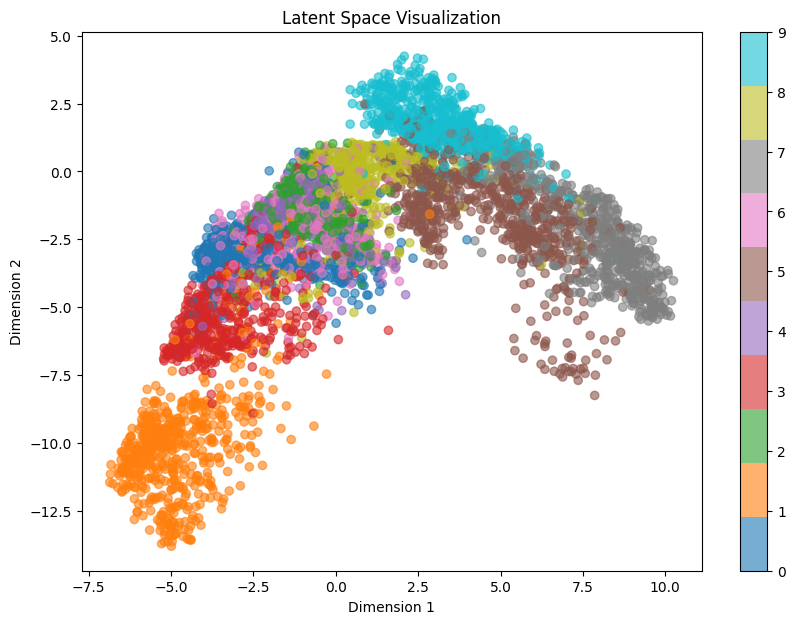

In [ ]:
# visualize latent space

def visualize_latent_space(model, dataloader, num_batches=100):
    model.eval()
    labels = []
    latents = []

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i >= num_batches: break
            X = X.to(device)
            X = X.view(-1, 28*28)
            _, latent = model(X)
            latents.append(latent.cpu())
            labels.append(y)

    latents = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)


    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    return latents

latents = visualize_latent_space(model, test_dataloader)


In [ ]:
latents

tensor([[  4.2720,   0.5997],
        [ -1.2640,  -0.5936],
        [ -6.4488, -11.0049],
        ...,
        [  9.4684,  -4.3699],
        [  0.7586,  -3.9666],
        [ -3.8012, -10.5290]])

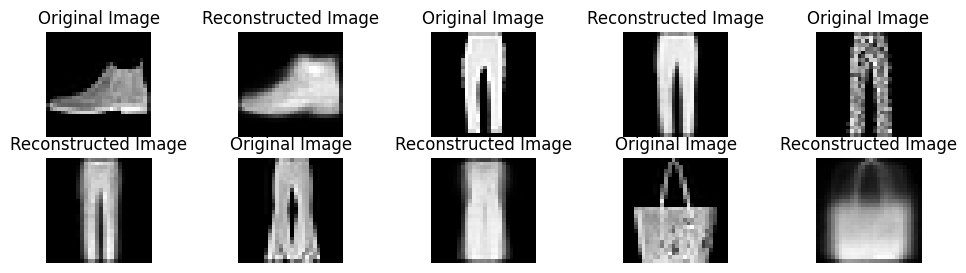

In [ ]:
# visualise reconstruction
def visualize_reconstructions(model, dataloader, num_images=5):
    model.eval()
    figure, axes = plt.subplots(2, num_images, figsize=(12, 3))
    axes = axes.flatten()

    with torch.no_grad():
        for i, (X, _) in enumerate(dataloader):
            if i >= num_images: break
            X = X.to(device)
            X_flat = X.view(-1, 28*28)
            decoded, _ = model(X_flat)

            axes[2*i].imshow(X[0].cpu().reshape(28, 28), cmap='gray')
            axes[2*i].set_title('Original Image')
            axes[2*i].axis('off')

            recon_img = decoded.view(-1, 28, 28)
            axes[2*i + 1].imshow(recon_img[0].cpu(), cmap='gray')
            axes[2*i + 1].set_title('Reconstructed Image')
            axes[2*i + 1].axis('off')

    plt.show()

visualize_reconstructions(model, test_dataloader)


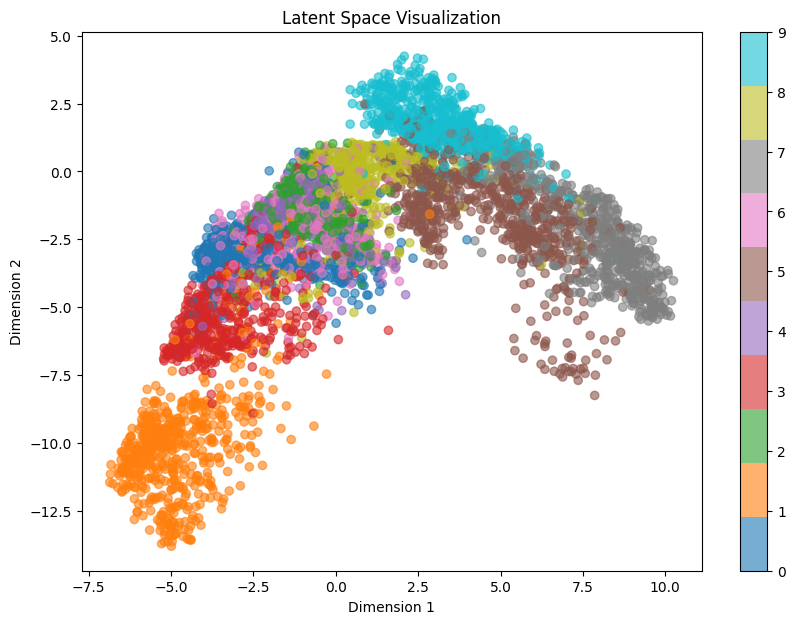

In [ ]:
def visualize_latent_space_and_return_images(model, dataloader, num_batches=100):
    model.eval()
    labels = []
    latents = []
    images = []  # Stocker les images pour visualisation ultérieure

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i >= num_batches: break
            X = X.to(device)
            original_X = X.view(X.size(0), 28, 28).cpu()  # Conserver les images originales
            X_flat = X.view(-1, 28*28)
            _, latent = model(X_flat)
            latents.append(latent.cpu())
            labels.append(y)
            images.append(original_X)  # Ajouter les images à la liste

    latents = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)  # Concaténation des images

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    return latents, images

latents, images = visualize_latent_space_and_return_images(model, test_dataloader)


tensor([-5.3654, -8.8966])


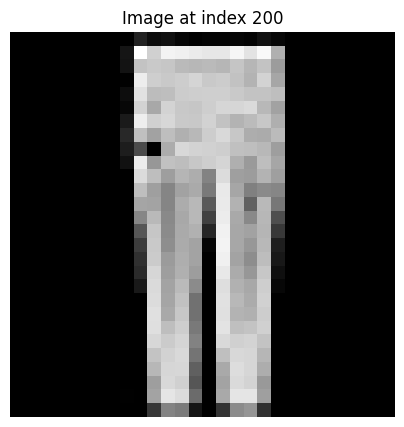

tensor([-2.0311, -3.1553])


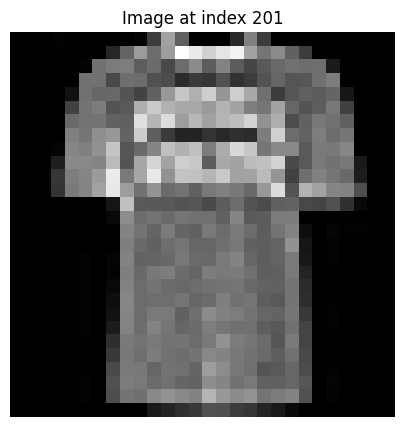

tensor([-0.6608, -2.0122])


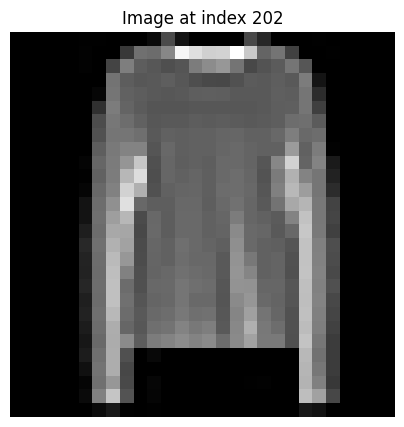

tensor([3.0426, 1.6144])


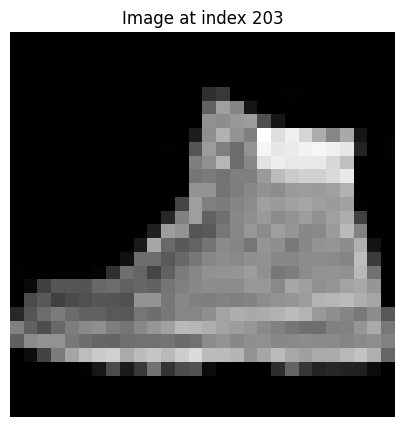

In [ ]:

for i in [200,201,202,203]:
  print(latents[i])
  img = images[i]
  plt.figure(figsize=(5, 5))
  plt.imshow(img, cmap='gray')
  plt.title(f'Image at index {i}')
  plt.axis('off')
  plt.show()
